# Determine Word to PCA Associations

This notebook is designed to run PCA over the document embeddings and calculate category-pca associations with each principal component.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook

In [2]:
journal_map_df = pd.read_csv(
    Path("..")/
    Path("exploratory_data_analysis")/
    Path("output/biorxiv_article_metadata.tsv"), 
    sep="\t"
)
journal_map_df.head()

,author_type,heading,category,document,doi
0,regular article,new results,genetics,440735_v1.xml,10.1101/440735
1,regular article,new results,systems biology,775270_v1.xml,10.1101/775270
2,regular article,new results,genetics,242404_v1.xml,10.1101/242404
3,regular article,new results,neuroscience,872994_v1.xml,10.1101/2019.12.11.872994
4,regular article,new results,developmental biology,080853_v2.xml,10.1101/080853


# PCA the Documents

Run PCA over the documents. Generates 50 principal components, but can generate more or less.

In [3]:
n_components = 50
random_state = 100

In [4]:
biorxiv_articles_df = pd.read_csv(
    Path("..")/
    Path("word_vector_experiment")/
    Path("output/word2vec_output")/
    Path("biorxiv_all_articles_300.tsv.xz"), 
    sep="\t"
)
biorxiv_articles_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,0.551382,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
1,775270_v1.xml,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,0.808698,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
2,242404_v1.xml,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,0.385497,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
3,872994_v1.xml,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,0.382142,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
4,080853_v2.xml,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,0.240977,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


In [5]:
reducer = PCA(
    n_components = n_components,
    random_state = random_state
)

reducer.fit(
    biorxiv_articles_df[[f"feat_{idx}" for idx in range(300)]]
    .values
)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

# Bootstrap 95% Confidence Intervals Cosine sim

In [6]:
document_categories_df = (
    journal_map_df[["document", "category"]]
    .merge(biorxiv_articles_df, on="document")
)
document_categories_df.head()

,document,category,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,genetics,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
1,775270_v1.xml,systems biology,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
2,242404_v1.xml,genetics,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
3,872994_v1.xml,neuroscience,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
4,080853_v2.xml,developmental biology,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


In [7]:
boostraped_iterations = 10000
pc_1 = []
pc_2 = []

for iteration in tqdm_notebook(range(boostraped_iterations)):
    sampled_df = (
        document_categories_df
        .groupby("category")
        .apply(lambda x: x.sample(1, random_state=iteration))
        .reset_index(drop=True)
        .sort_values("category")
    )
    
    document_distance = (
        1 - cdist(
            sampled_df
            .drop(["document", "category"], axis=1)
            .values, 
            reducer.components_[0:2], 
            'cosine'
        )
    )
    
    pc_1.append(document_distance[:, 0])
    pc_2.append(document_distance[:, 1])

pc_1 = np.stack(pc_1)
pc_2 = np.stack(pc_2)

In [8]:
mean_similarity_df = (
    pd.DataFrame(
        (
            1 - cdist(
                document_categories_df
                .drop(["document", "category"], axis=1)
                .values, 
                reducer.components_[0:2], 
                'cosine'
            )
        ),
        columns=["pca1_cossim", "pca2_cossim"]
    )
    .assign(
        category = document_categories_df.category.tolist(),
        document = document_categories_df.document.tolist()
    )
)
mean_similarity_df.head()

,pca1_cossim,pca2_cossim,category,document
0,0.610555,0.279363,genetics,440735_v1.xml
1,0.620834,0.081065,systems biology,775270_v1.xml
2,0.703045,0.277774,genetics,242404_v1.xml
3,0.675625,-0.145204,neuroscience,872994_v1.xml
4,-0.077342,-0.084322,developmental biology,080853_v2.xml


In [9]:
category_sim_df = (
    mean_similarity_df
    .groupby("category")
    .agg({
        "pca1_cossim": "mean",
        "pca2_cossim": "mean"
    })
    .assign(
        pca1_cossim_upper = np.percentile(pc_1, 97.5, axis=0),
        pca1_cossim_lower = np.percentile(pc_1, 25, axis=0),
        pca2_cossim_upper = np.percentile(pc_2, 97.5, axis=0),
        pca2_cossim_lower = np.percentile(pc_2, 25, axis=0)
    )
    .reset_index()
    [
        [
            "category", "pca1_cossim_lower",
            "pca1_cossim", "pca1_cossim_upper",
            "pca2_cossim_lower", "pca2_cossim",
            "pca2_cossim_upper"
        ]
    ]
)
category_sim_df.head()

,category,pca1_cossim_lower,pca1_cossim,pca1_cossim_upper,pca2_cossim_lower,pca2_cossim,pca2_cossim_upper
0,animal behavior and cognition,0.471002,0.545649,0.762264,-0.245143,-0.148315,0.112117
1,biochemistry,-0.155202,-0.002660,0.515425,0.015315,0.106509,0.363571
2,bioengineering,-0.008367,0.236242,0.703002,-0.201939,-0.064890,0.395261
3,bioinformatics,0.473054,0.541005,0.729255,0.177293,0.272429,0.531561
4,biophysics,0.116858,0.270130,0.637505,-0.172122,-0.069720,0.227069


In [10]:
category_sim_df.to_csv(
    "output/category_cossim_95_ci.tsv", 
    sep="\t", index=False
)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca1_95_ci.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca1_95_ci.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


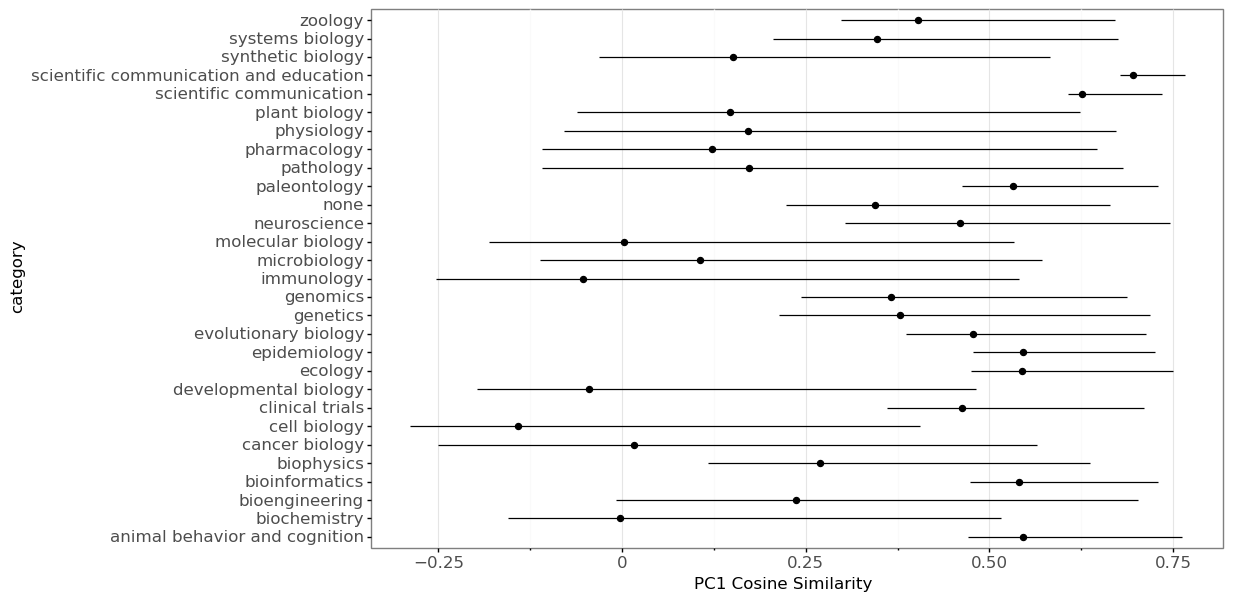

<ggplot: (8732989661616)>


In [14]:
g = (
    p9.ggplot(category_sim_df)
    + p9.aes(
        x="category", y="pca1_cossim",
        ymin="pca1_cossim_lower", ymax="pca1_cossim_upper"
    )
    + p9.geom_pointrange()
    + p9.coord_flip()
    + p9.theme_bw()
    #+ p9.scale_x_discrete(limits=category_sim_df.category.tolist()[::-1])
    + p9.theme(
        figure_size=(11, 7),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank()
    )
    + p9.labs(
        y = "PC1 Cosine Similarity"
    )
)
g.save("output/pca_plots/figures/category_pca1_95_ci.svg", dpi=500)
g.save("output/pca_plots/figures/category_pca1_95_ci.png", dpi=500)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca2_95_ci.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca2_95_ci.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


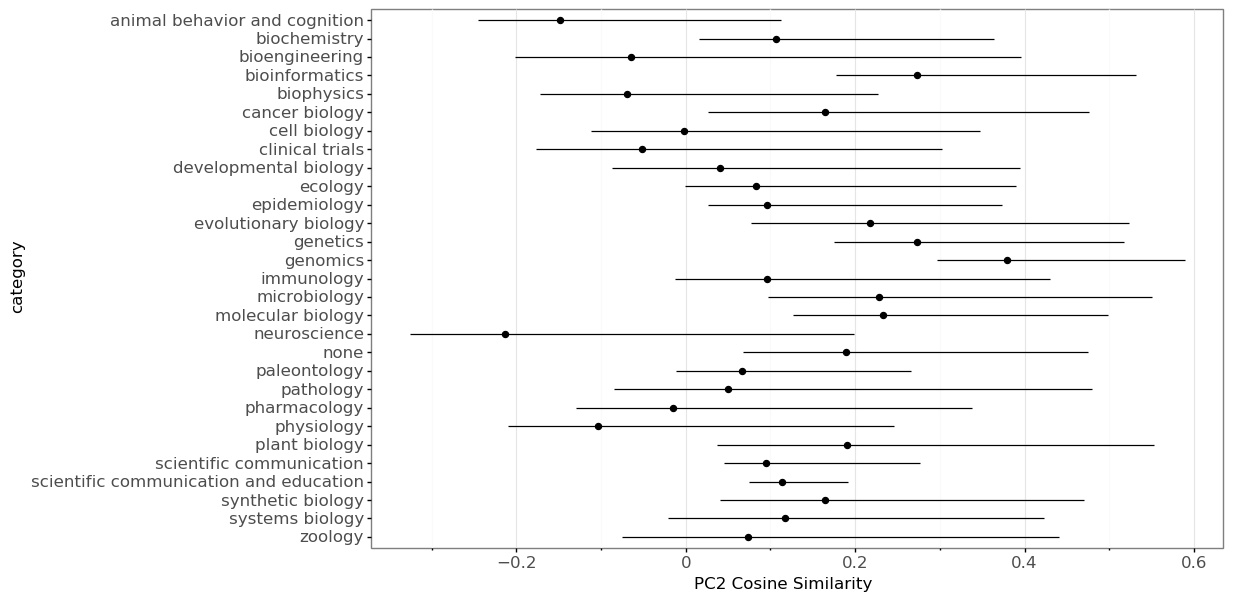

<ggplot: (-9223363303831337756)>


In [13]:
g = (
    p9.ggplot(category_sim_df)
    + p9.aes(
        x="category", y="pca2_cossim", 
        ymax="pca2_cossim_upper", ymin="pca2_cossim_lower"
    )
    + p9.geom_pointrange()
    + p9.coord_flip()
    + p9.theme_bw()
    + p9.scale_x_discrete(limits=category_sim_df.category.tolist()[::-1])
    + p9.theme(
        figure_size=(11, 7),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank()
    )
    + p9.labs(
        y = "PC2 Cosine Similarity"
    )
)
g.save("output/pca_plots/figures/category_pca2_95_ci.svg", dpi=500)
g.save("output/pca_plots/figures/category_pca2_95_ci.png", dpi=500)
print(g)